### Importing Modules (p 544)

In [1]:
import pymc3 as mc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula as smf
import seaborn as sns

%matplotlib inline

### Introduction to Bayesian Statiscis (p 545)

### Model Definition (p 548)

In [2]:
# define the fixed model parameters
mu, sigma = 4.0, 2.0

# create an instance of mc.Model to represent the model
model = mc.Model()

In [3]:
# attach random variables to the model
with model:
    mc.Normal('X', mu, tau=1/sigma**2)

In [4]:
# inspect which random variables exist in a model
model.vars

[X]

In [5]:
# provide a starting point
start = dict(X=2)

with model:
    # pass a step class instance that implements an MCMC step
    step = mc.Metropolis()
    # sample from the random variables in the model
    trace = mc.sample(10000, start=start, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [X]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:04<00:00, 9370.31draws/s] 
The number of effective samples is smaller than 25% for some parameters.


In [6]:
# access the samples
X = trace.get_values("X")

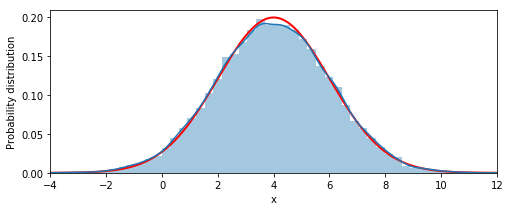

In [7]:
# compare PDF of the normal distributin and the sampled random variable
x = np.linspace(-4, 12, 1000)
y = stats.norm(mu, sigma).pdf(x)
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, y, 'r', lw=2)
sns.distplot(X, ax=ax)
ax.set_xlim(-4, 12)
ax.set_xlabel('x')
ax.set_ylabel("Probability distribution");

In [8]:
# create dependent random variable X
model = mc.Model()
with model:
    mean = mc.Normal('mean', 3.0)
    sigma = mc.HalfNormal('sigma', sd=1.0)
    X = mc.Normal('X', mean, sd=sigma)

In [9]:
# inspect which random variables of a model
model.vars

[mean, sigma_log__, X]

In [10]:
# find the point in the parameter space that corresponds
# to the maximum of the posterior distribution
with model:
    start = mc.find_MAP()
start

logp = -2.1562, ||grad|| = 1.6366: 100%|██████████| 8/8 [00:00<00:00, 2234.73it/s]


{'mean': array(3.),
 'sigma_log__': array(-674.07720733),
 'X': array(3.),
 'sigma': array(1.78644019e-293)}

In [11]:
# sample from the random variables in the model
with model:
    step = mc.Metropolis()
    trace = mc.sample(100000, start=start, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [X]
>Metropolis: [sigma]
>Metropolis: [mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402000 [01:05<00:00, 6108.90draws/s]
/Users/geeyeol/.pyenv/versions/3.7.1/envs/python3-staging/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [12]:
# obtain the sample trace for the sigma variable
trace.get_values('sigma').mean()

1.7864401850541627e-293

In [13]:
# obtain the samples of X
X = trace.get_values('X')

# compute statistics
X.mean(), trace.get_values('X').std()

(3.0, 0.0)

#### Sampling Posterior Distributions (p 553)

In [14]:
# simulate the observations for X by drawing samples from
# a normally distributed random variable with u=2.5, s=1.5
mu, s = 2.5, 1.5
data = stats.norm(mu, s).rvs(100)

In [15]:
# feed data into the model
with mc.Model() as model:
    
    mean = mc.Normal('mean', 4.0, 1.0)
    sigma = mc.HalfNormal('sigma', 3.0 * np.sqrt(np.pi/2))
    X = mc.Normal('X', mean, 1/sigma**2, observed=data)

In [16]:
# inspect the model to check whether X is still a random variable
model.vars

[mean, sigma_log__]

In [17]:
# sample the posterior distribution
with model:
    start = mc.find_MAP()
    step = mc.Metropolis()
    trace = mc.sample(100000, start=start, step=step)

logp = -191.22, ||grad|| = 69.199: 100%|██████████| 18/18 [00:00<00:00, 2254.80it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402000 [00:55<00:00, 7255.12draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [18]:
# the starting point maximizes the likelihood of the posterior
# given the observed data and provides an estimate of the
# unknown parameters
start

{'mean': array(2.63246905),
 'sigma_log__': array(-0.2094103),
 'sigma': array(0.81106239)}

In [19]:
# compute estimates of the mean of the two random variables in the
# model and compare to the corresopnding true values for the
# distributinos that the data points were drawn from
print(mu, trace.get_values('mean').mean())
print(s, trace.get_values('sigma').mean())

2.5 2.632177541281455
1.5 0.8085908379735686


/Users/geeyeol/.pyenv/versions/3.7.1/envs/python3-staging/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


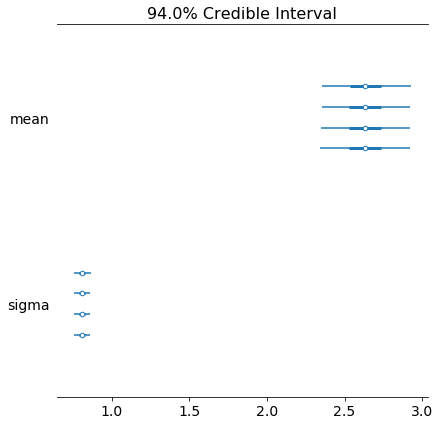

In [20]:
# visualize the mean and credibility intervals for each random variable
mc.forestplot(trace, varnames=['mean', 'sigma']);

In [21]:
# print the mean and credibility intervals for each random variable
mc.summary(trace, varnames=['mean', 'sigma'])

/Users/geeyeol/.pyenv/versions/3.7.1/envs/python3-staging/lib/python3.7/site-packages/pymc3/stats/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,2.632,0.153,2.349,2.922,0.001,0.0,62677.0,62677.0,62576.0,63795.0,1.0
sigma,0.809,0.029,0.756,0.863,0.000,0.0,42706.0,42706.0,42760.0,44059.0,1.0


#### Linear Regression (p 558)

In [22]:
# load data
dataset = sm.datasets.get_rdataset("Davis", "carData")

In [23]:
# select the subset of the datasets
data = dataset.data[dataset.data.sex == "M"]
data = data[data.weight < 110]
data.head(3)

,sex,weight,height,repwt,repht
0,M,77,182,77.0,180.0
3,M,68,177,70.0,175.0
5,M,76,170,76.0,165.0


In [24]:
# create a statistical model
# use smf.api.ols instead of smf.ols
model = smf.api.ols("height ~ weight", data=data)

In [25]:
# fit the model
result = model.fit()

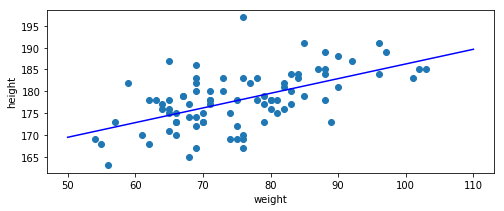

In [26]:
x = np.linspace(50, 110, 25)
y = result.predict({"weight": x})
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(data.weight, data.height, 'o')
ax.plot(x, y , color='blue')
ax.set_xlabel('weight')
ax.set_ylabel('height');

In [27]:
with mc.Model() as model:
    
    # create random variables for the stochastic components of the model
    sigma = mc.Uniform('sigma', 0, 10)
    intercept = mc.Normal('intercept', 125, sd=30)
    beta = mc.Normal('beta', 0, sd=5)
    
    # create a deterministic variable that are functions of the stochastic
    # variables but with observed ata attached
    height_mu = intercept + beta * data.weight
    mc.Normal('height', mu=height_mu, sd=sigma, observed=data.height)
    predict_height = mc.Normal('predict_height', mu=intercept + beta * x, sd=sigma, shape=len(x))

In [28]:
# model contains two model parameters, the distribution of the model errors
# and the predict_height variable for predicting the heights at specific
# values of weight
model.vars

[sigma_interval__, intercept, beta, predict_height]

In [29]:
# find a suitable starting point to sample marginal posterior
# distribution for the model
with model:
    start = mc.find_MAP()
    step = mc.NUTS()
    trace = mc.sample(10000, step, start=start);

logp = -382.7, ||grad|| = 9.9702: 100%|██████████| 37/37 [00:00<00:00, 2323.54it/s]   
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [predict_height, beta, intercept, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:56<00:00, 737.86draws/s]
The acceptance probability does not match the target. It is 0.88675885748217, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9007428864135738, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9053953183869344, but should be close to 0.8. Try to increase the number of tuning steps.


In [30]:
# obtain the values of the intercept and coefficient in the linear model
intercept = trace.get_values("intercept").mean()
beta = trace.get_values("beta").mean()

intercept, beta

(152.09329179795787, 0.34327100493624274)

In [31]:
# obtain the corresponding result from the statsmodels analysis
result.params

Intercept    152.617348
weight         0.336477
dtype: float64

In [32]:
# predict the expected height in the statsmodels approach
result.predict({"weight": 90}).values

array([182.90030002])

In [33]:
# obtain the corresponding result in the Bayesian model by
# computing the mean for the distribution of the stochastic variables
weight_index = np.where(x == 90)[0][0]
trace.get_values("predict_height")[:, weight_index].mean()

182.99650039381726

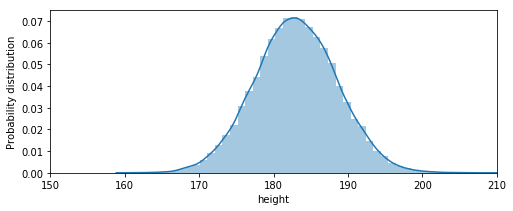

In [34]:
# plot a histogram and the kernel density estimate of the probability
# distributin for the weight 90kg
fig, ax = plt.subplots(figsize=(8, 3))
sns.distplot(trace.get_values("predict_height")[:, weight_index], ax=ax)
ax.set_xlim(150, 210)
ax.set_xlabel("height")
ax.set_ylabel("Probability distribution");

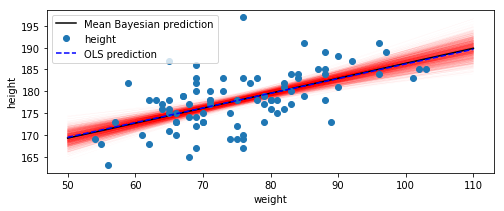

In [35]:
# visualize the uncertainty in the mean intercept and coefficient that
# we an take as estimates of the final linear model parameters
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
for n in range(500, 2000, 1):
    intercept = trace.get_values("intercept")[n]
    beta = trace.get_values("beta")[n]
    ax.plot(x, intercept + beta * x, color='red', lw=0.25, alpha=0.05)
    
intercept = trace.get_values("intercept").mean()
beta = trace.get_values("beta").mean()
ax.plot(x, intercept + beta * x, color='k', label="Mean Bayesian prediction")
ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, '--', color="blue", label="OLS prediction")
ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0);

In [36]:
with mc.Model() as model:
    # define a generalized linear model and provide data using a Pandas DataFrame
    mc.glm.GLM.from_formula('height ~ weight', data)
    
    # sample from the posterior distributin of the model
    step = mc.NUTS()
    trace = mc.sample(2000, step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, weight, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:07<00:00, 1317.96draws/s]
The acceptance probability does not match the target. It is 0.931880878198038, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9278669315868158, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860256949941719, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9241679229722698, but should be close to 0.8. Try to increase the number of tuning steps.


In [37]:
# load the dataset
data = dataset.data.copy()
data = data[data.weight < 110]

# convert the sex column to a binary variable (0, 1)
data['sex'] = data['sex'].apply(lambda x: 1 if x == "F" else 0)

In [38]:
with mc.Model() as model:
    
    intercept_mu, intercept_sigma = 125, 30
    beta_mu, beta_sigma = 0, 5
    
    # indicate the multilevel structure by specifying shape=2
    intercept = mc.Normal('intercept', intercept_mu, sd=intercept_sigma, shape=2)
    beta = mc.Normal('beta', beta_mu, sd=beta_sigma, shape=2)
    
    error = mc.Uniform('error', 0, 10)
    
    # use an index mask so that each value in data.weight is associated
    # with the correct level
    sex_idx = data.sex.values
    height_mu = intercept[sex_idx] + beta[sex_idx] * data.weight
    
    mc.Normal('height', mu=height_mu, sd=error, observed=data.height)

In [39]:
# obtain model variables
model.vars

[intercept, beta, error_interval__]

In [40]:
# collect 5000 samples using NUTS sampler
with model:
    start = mc.find_MAP()
    step = mc.NUTS()
    trace = mc.sample(5000, step, start=start)

logp = -618.03, ||grad|| = 8.8049: 100%|██████████| 51/51 [00:00<00:00, 2040.15it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, beta, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:26<00:00, 832.42draws/s]


In [41]:
# extract the intercept and the slope for each gender
intercept_m, intercept_f = trace.get_values('intercept').mean(axis=0)
beta_m, beta_f = trace.get_values('beta').mean(axis=0)

In [42]:
# get the intercept and the slope that represent the entire dataset
# by averaging over both dimensinos (axis=0, 1)
intercept = trace.get_values('intercept').mean()
beta = trace.get_values('beta').mean()

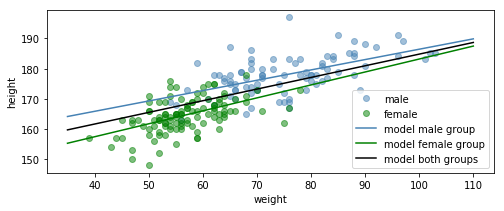

In [43]:
# plot the data as scatter plots and draw the lines corresponding
# to the intercetps and slopes and the result from grouping all subjects
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
mask_m = data.sex == 0
mask_f = data.sex == 1

ax.plot(data.weight[mask_m], data.height[mask_m], 'o', color="steelblue", label="male", alpha=0.5)
ax.plot(data.weight[mask_f], data.height[mask_f], 'o', color="green", label="female", alpha=0.5)

x = np.linspace(35, 110, 50)
ax.plot(x, intercept_m + x * beta_m, color="steelblue", label="model male group")
ax.plot(x, intercept_f + x * beta_f, color="green", label="model female group")
ax.plot(x, intercept + x * beta, color="black", label="model both groups")

ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0);